In [1]:
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier, XGBRegressor

In [2]:
train_df = pd.read_csv('/content/gooppang.csv')
test_df = pd.read_csv('/content/current_users.csv')

# Model building 

## Checkout estimation (coupon effect)

In [3]:
# Checkout estimation
checkout_ct = ColumnTransformer([
  ('bin', 'passthrough', ['coupon', 'subscriber']),
  ('cat', OneHotEncoder(), ['region', 'gender']),
  ('num', StandardScaler(), ['age', 'monthly_spend', 'tenure']),
])
checkout_pipe = Pipeline([
  ('trans', checkout_ct),
  ('clf', XGBClassifier(random_state=0)),
])
checkout_estimator = checkout_pipe.fit(train_df, y=train_df.checkout)

## Basket prediction

In [4]:
# Basket estimation
basket_ct = ColumnTransformer([
  ('bin', 'passthrough', ['subscriber']),
  ('cat', OneHotEncoder(), ['region', 'gender']),
  ('num', StandardScaler(), ['age', 'monthly_spend', 'tenure']),
])
basket_pipe = Pipeline([
  ('trans', basket_ct),
  ('reg', XGBRegressor(random_state=0)),
])
basket_pipe = basket_pipe.fit(train_df, y=train_df.basket)

[03:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Shipping fee estimation

In [5]:
# Shipping estimation
shipping_fee_ct = ColumnTransformer([
  ('num', 'passthrough', ['basket']),
  ('cat', OneHotEncoder(), ['region']),
])
shipping_fee_pipe = Pipeline([
  ('trans', shipping_fee_ct),
  ('reg', XGBRegressor(random_state=0)),
])
shipping_fee_pipe = shipping_fee_pipe.fit(train_df, y=train_df.shipping_fee)

[03:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Metric computation

In [6]:
# P(checkout | coupon)
p_checkout_with_coupon = checkout_estimator.predict_proba(test_df.assign(coupon=1))[:, 1]
p_checkout_no_coupon = checkout_estimator.predict_proba(test_df.assign(coupon=0))[:, 1]

In [7]:
metrics_df = (
  test_df
  .assign(
    # Coupon effect
    p_checkout_no_coupon=p_checkout_no_coupon,
    p_checkout_with_coupon=p_checkout_with_coupon,
    coupon_effect=p_checkout_with_coupon - p_checkout_no_coupon,
    # Actual shipping fee estimation
    basket=basket_pipe.predict,
    shipping_fee=shipping_fee_pipe.predict,
    actual_shipping=lambda d: d.shipping_fee * (1 - d.subscriber),
    # Spend, effect per spend estimation
    coupon_spend=lambda d: d.p_checkout_with_coupon * d.actual_shipping,
    effect_per_spend=lambda d: d.coupon_effect / d.coupon_spend,
    # Revenue estimation
    base_revenue=lambda d: d.p_checkout_no_coupon * d.basket,
    coupon_revenue=lambda d: d.p_checkout_with_coupon * d.basket,
    marginal_revenue=lambda d: d.coupon_revenue - d.base_revenue,
    marginal_profit=lambda d: d.coupon_revenue - d.base_revenue - d.coupon_spend,
  )
)

In [8]:
def compute_results(df, sort_by, ascending):
    n, _ = df.shape
    return (
      df
      .sort_values([sort_by], ascending=ascending)
      .reset_index(drop=True)
      .assign(
        cum_marginal_revenue=lambda d: d.marginal_revenue.cumsum(),
        cum_marginal_profit=lambda d: d.marginal_profit.cumsum(),
        cum_spend=lambda d: d.coupon_spend.cumsum(),
        est_increase=lambda d: (
          d.p_checkout_with_coupon.cumsum()/n
          - d.p_checkout_no_coupon.cumsum()/n
        ),
        est_checkout=lambda d: (
          p_checkout_no_coupon.mean() + d.est_increase
        ),
        ones=1,
        p_coupon=lambda d: d.ones.cumsum() / n,
        sort_by=sort_by,
      )
    )

In [9]:
result_df = pd.concat([
    compute_results(metrics_df, 'coupon_effect', False),
    compute_results(metrics_df, 'effect_per_spend', False),
    compute_results(metrics_df, 'marginal_revenue', False),
    compute_results(metrics_df, 'marginal_profit', False),
]).reset_index(drop=True)

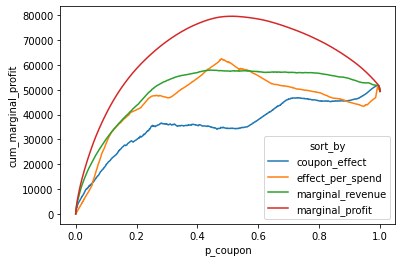

In [10]:
sns.lineplot(
    x='p_coupon',
    y='cum_marginal_profit',
    hue='sort_by',
    data=result_df,
    ci=None)

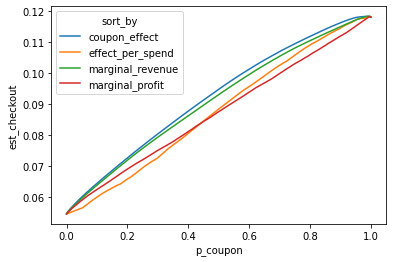

In [11]:
sns.lineplot(
    x='p_coupon',
    y='est_checkout',
    hue='sort_by',
    data=result_df,
    ci=None)

In [14]:
(
    result_df[(result_df.marginal_profit > 0) &
              (result_df.sort_by == 'marginal_profit')]
    .nlargest(1, 'p_coupon')
    .loc[:, ['p_coupon', 'cum_marginal_revenue', 'cum_spend',
             'cum_marginal_profit', 'est_checkout', 'est_increase']]
)

,p_coupon,cum_marginal_revenue,cum_spend,cum_marginal_profit,est_checkout,est_increase
502421,0.513441,190286.125,110693.460938,79597.539062,0.088465,0.033904
